In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define hyperparameters
batch_size = 64
num_epochs = 10
learning_rate = 0.001
num_classes = 10  # CIFAR-10 has 10 classes

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='/tmp/data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='/tmp/data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 170M/170M [00:04<00:00, 35.4MB/s]


Extracting /tmp/data/cifar-10-python.tar.gz to /tmp/data
Files already downloaded and verified


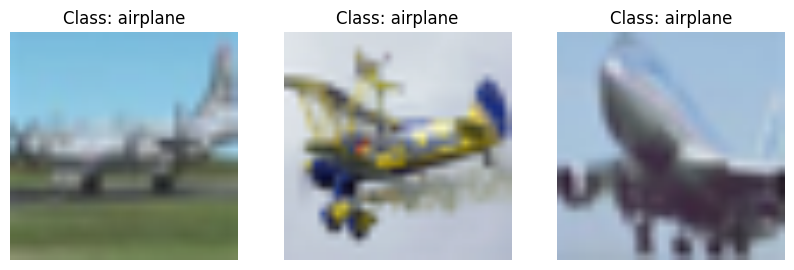

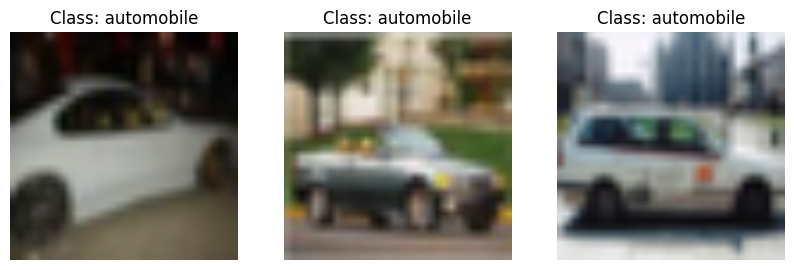

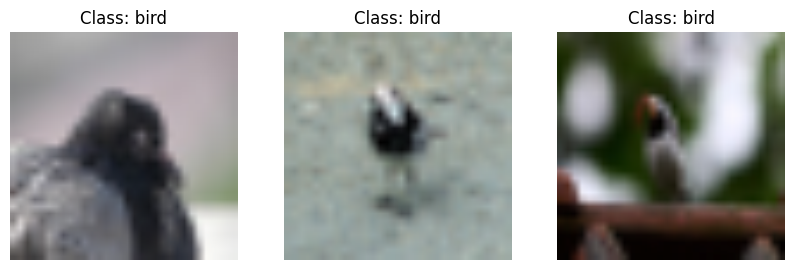

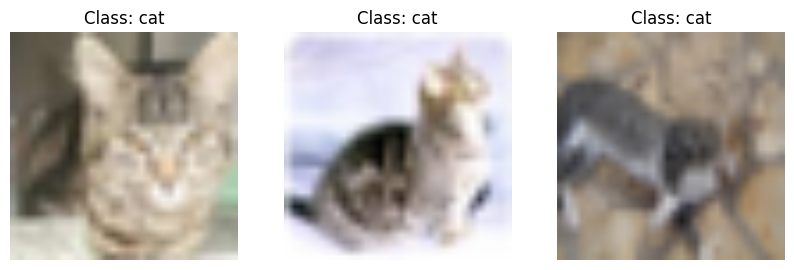

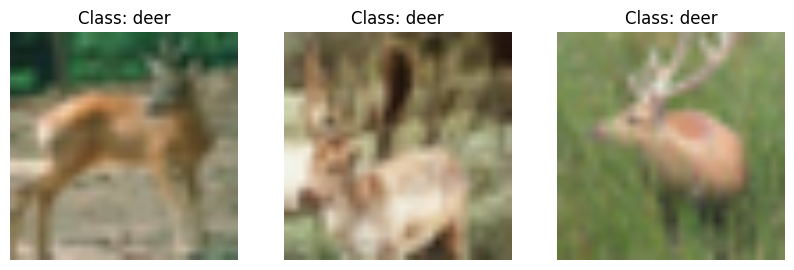

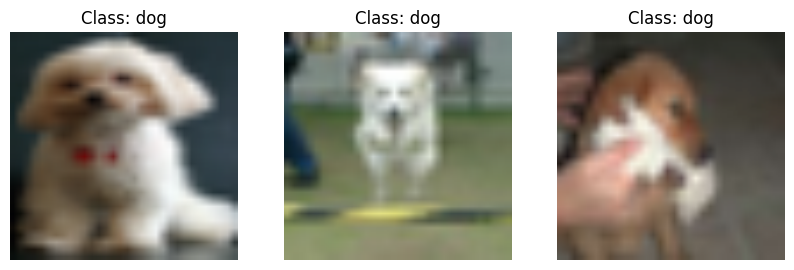

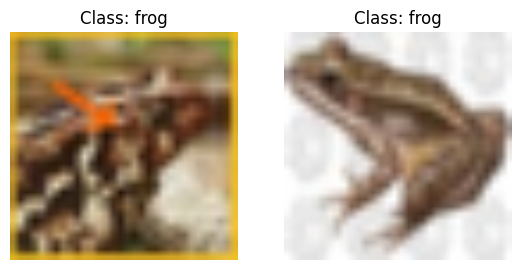

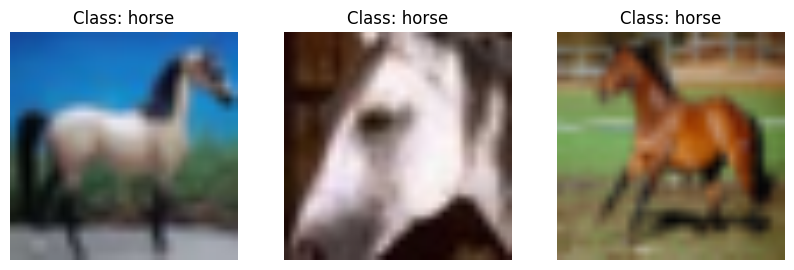

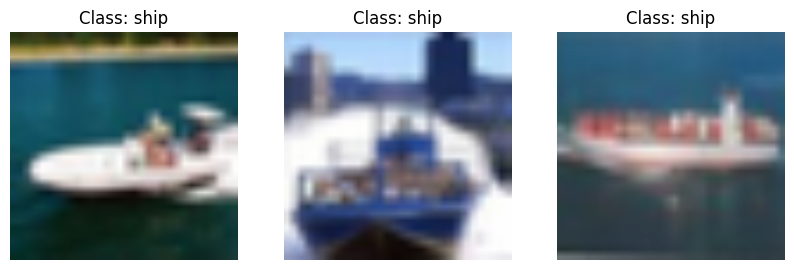

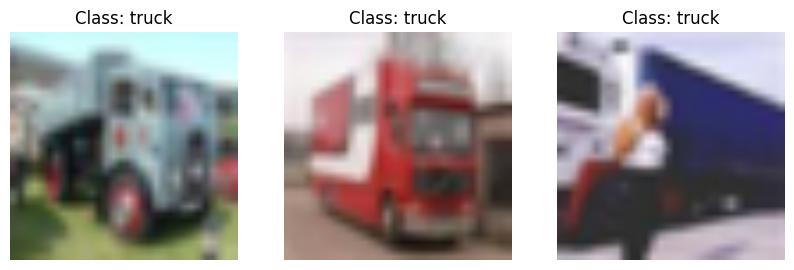

In [3]:
# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define the class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot some sample images from each class
num_classes_to_plot = 10  # Number of classes to show samples for
num_samples_per_class = 3 # Number of samples to show per class

for class_idx in range(num_classes_to_plot):
  class_images = []
  class_labels = []

  for i in range(len(labels)):
    if labels[i] == class_idx:
        class_images.append(images[i])
        class_labels.append(labels[i])
        if len(class_images) >= num_samples_per_class:
            break

  if class_images:
      plt.figure(figsize=(10, 5))
      for i in range(len(class_images)):
          plt.subplot(1, num_samples_per_class, i + 1)
          img = class_images[i].numpy().transpose((1, 2, 0))
          mean = np.array([0.4914, 0.4822, 0.4465])
          std = np.array([0.2023, 0.1994, 0.2010])
          img = std * img + mean
          img = np.clip(img, 0, 1)
          plt.imshow(img)
          plt.title(f"Class: {class_names[class_labels[i]]}")
          plt.axis('off')
      plt.show()


In [4]:
# Define training and testing functions
def train(model, device, train_loader, criterion, optimizer, epoch, model_name):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f"Training {model_name} - Epoch {epoch+1}", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        progress_bar.set_postfix(loss=running_loss / total, accuracy=100. * correct / total)

    return running_loss / total, 100. * correct / total

def test(model, device, test_loader, criterion, epoch, model_name):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(test_loader, desc=f"Testing {model_name} - Epoch {epoch+1}", leave=False)
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            progress_bar.set_postfix(loss=running_loss / total, accuracy=100. * correct / total)

    return running_loss / total, 100. * correct / total

In [5]:
# Function to initialize models
def initialize_model(model_name):
    if model_name == "resnet18":
        from torchvision.models import ResNet18_Weights
        model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    elif model_name == "alexnet":
        from torchvision.models import AlexNet_Weights
        model = models.alexnet(weights=AlexNet_Weights.DEFAULT)
    elif model_name == "mobilenet_v2":
        from torchvision.models import MobileNet_V2_Weights
        model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
    else:
        raise ValueError("Model not supported")

    # Modify the final layer to match CIFAR-10 classes
    if model_name == "resnet18":
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "alexnet":
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == "mobilenet_v2":
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)

    return model

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [6]:
# Function to train and test a specific model
def train_and_evaluate_model(model_name, device, num_epochs, train_loader, test_loader):
    print(f"\nTraining {model_name}...")
    model = initialize_model(model_name).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Assuming learning_rate is defined

    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch, model_name)
        test_loss, test_acc = test(model, device, test_loader, criterion, epoch, model_name)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # Save results
    results = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_accuracy": train_accuracies,
        "test_accuracy": test_accuracies
    }

    print(f"\nResults for {model_name}:")
    print(f"Final Train Accuracy: {results['train_accuracy'][-1]:.2f}%")
    print(f"Final Test Accuracy: {results['test_accuracy'][-1]:.2f}%")
    print(f"Final Train Loss: {results['train_loss'][-1]:.4f}")
    print(f"Final Test Loss: {results['test_loss'][-1]:.4f}")

    # Save the model weights
    torch.save(model.state_dict(), f"{model_name}_model.pth")
    print(f"Model weights saved to: {model_name}_model.pth")

    return results

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
# Run ResNet18
resnet18_results = train_and_evaluate_model("resnet18", device, num_epochs, train_loader, test_loader)


Training resnet18...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


Epoch [1/10], Train Loss: 0.5574, Train Acc: 81.06% | Test Loss: 0.4638, Test Acc: 84.40%


Epoch [2/10], Train Loss: 0.3403, Train Acc: 88.48% | Test Loss: 0.3607, Test Acc: 87.90%


Epoch [3/10], Train Loss: 0.2627, Train Acc: 90.86% | Test Loss: 0.3490, Test Acc: 88.33%


Epoch [4/10], Train Loss: 0.2066, Train Acc: 92.83% | Test Loss: 0.3079, Test Acc: 89.93%


Epoch [5/10], Train Loss: 0.1762, Train Acc: 93.81% | Test Loss: 0.3204, Test Acc: 89.64%


Epoch [6/10], Train Loss: 0.1491, Train Acc: 94.83% | Test Loss: 0.3004, Test Acc: 90.34%


Epoch [7/10], Train Loss: 0.1278, Train Acc: 95.51% | Test Loss: 0.3271, Test Acc: 90.10%


Epoch [8/10], Train Loss: 0.1080, Train Acc: 96.23% | Test Loss: 0.3060, Test Acc: 90.74%


Epoch [9/10], Train Loss: 0.0971, Train Acc: 96.68% | Test Loss: 0.3308, Test Acc: 90.69%


Epoch [10/10], Train Loss: 0.0824, Train Acc: 97.15% | Test Loss: 0.2875, Test Acc: 92.06%

Results for resnet18:
Final Train Accuracy: 97.15%
Final Test Accuracy: 92.06%
Final Train Loss: 0.0824
Final Test Loss: 0.2875
Model weights saved to: resnet18_model.pth


In [8]:
# Run AlexNet
alexnet_results = train_and_evaluate_model("alexnet", device, num_epochs, train_loader, test_loader)


Training alexnet...


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:06<00:00, 38.7MB/s]


Epoch [1/10], Train Loss: 1.7833, Train Acc: 33.99% | Test Loss: 1.5115, Test Acc: 44.63%


Epoch [2/10], Train Loss: 1.3392, Train Acc: 51.90% | Test Loss: 1.1492, Test Acc: 58.81%


Epoch [3/10], Train Loss: 1.1374, Train Acc: 59.92% | Test Loss: 1.0686, Test Acc: 62.74%


Epoch [4/10], Train Loss: 1.0372, Train Acc: 63.93% | Test Loss: 0.9630, Test Acc: 66.82%


Epoch [5/10], Train Loss: 0.9740, Train Acc: 66.33% | Test Loss: 0.8964, Test Acc: 69.19%


Epoch [6/10], Train Loss: 0.9304, Train Acc: 68.09% | Test Loss: 0.8715, Test Acc: 70.28%


Epoch [7/10], Train Loss: 0.8932, Train Acc: 69.49% | Test Loss: 0.8927, Test Acc: 69.79%


Epoch [8/10], Train Loss: 0.8715, Train Acc: 70.52% | Test Loss: 0.8328, Test Acc: 71.24%


Epoch [9/10], Train Loss: 0.8322, Train Acc: 71.62% | Test Loss: 0.8191, Test Acc: 72.12%


Epoch [10/10], Train Loss: 0.8217, Train Acc: 72.04% | Test Loss: 0.7795, Test Acc: 74.65%

Results for alexnet:
Final Train Accuracy: 72.04%
Final Test Accuracy: 74.65%
Final Train Loss: 0.8217
Final Test Loss: 0.7795
Model weights saved to: alexnet_model.pth


In [9]:
# Run MobileNetV2
mobilenet_v2_results = train_and_evaluate_model("mobilenet_v2", device, num_epochs, train_loader, test_loader)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth



Training mobilenet_v2...


100%|██████████| 13.6M/13.6M [00:03<00:00, 4.24MB/s]


Epoch [1/10], Train Loss: 0.4479, Train Acc: 85.13% | Test Loss: 0.3064, Test Acc: 89.35%


Epoch [2/10], Train Loss: 0.2713, Train Acc: 90.82% | Test Loss: 0.3054, Test Acc: 89.64%


Epoch [3/10], Train Loss: 0.2213, Train Acc: 92.39% | Test Loss: 0.2651, Test Acc: 91.13%


Epoch [4/10], Train Loss: 0.1863, Train Acc: 93.71% | Test Loss: 0.2731, Test Acc: 91.23%


Epoch [5/10], Train Loss: 0.1651, Train Acc: 94.31% | Test Loss: 0.2496, Test Acc: 91.90%


Epoch [6/10], Train Loss: 0.1443, Train Acc: 95.00% | Test Loss: 0.2474, Test Acc: 91.92%


Epoch [7/10], Train Loss: 0.1297, Train Acc: 95.47% | Test Loss: 0.2437, Test Acc: 92.25%


Epoch [8/10], Train Loss: 0.1216, Train Acc: 95.81% | Test Loss: 0.2727, Test Acc: 91.75%


Epoch [9/10], Train Loss: 0.1126, Train Acc: 96.07% | Test Loss: 0.2338, Test Acc: 92.87%


Epoch [10/10], Train Loss: 0.0948, Train Acc: 96.67% | Test Loss: 0.2255, Test Acc: 93.27%

Results for mobilenet_v2:
Final Train Accuracy: 96.67%
Final Test Accuracy: 93.27%
Final Train Loss: 0.0948
Final Test Loss: 0.2255
Model weights saved to: mobilenet_v2_model.pth


<ipython-input-10-f354fdf02ee2>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18_model.load_state_dict(torch.load("resnet18_model.pth")) # Load your trained model 

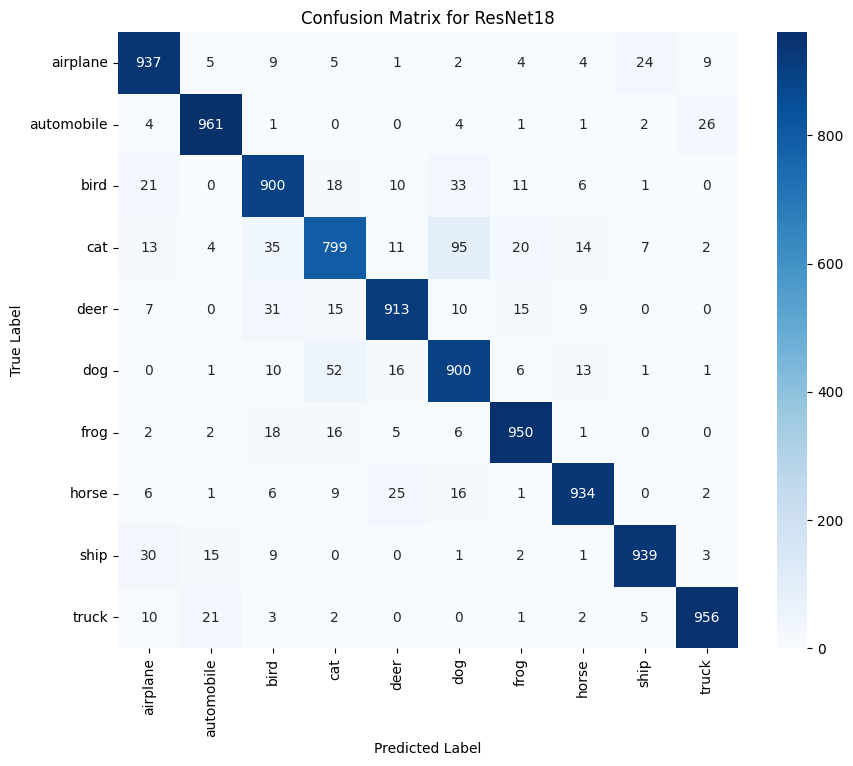

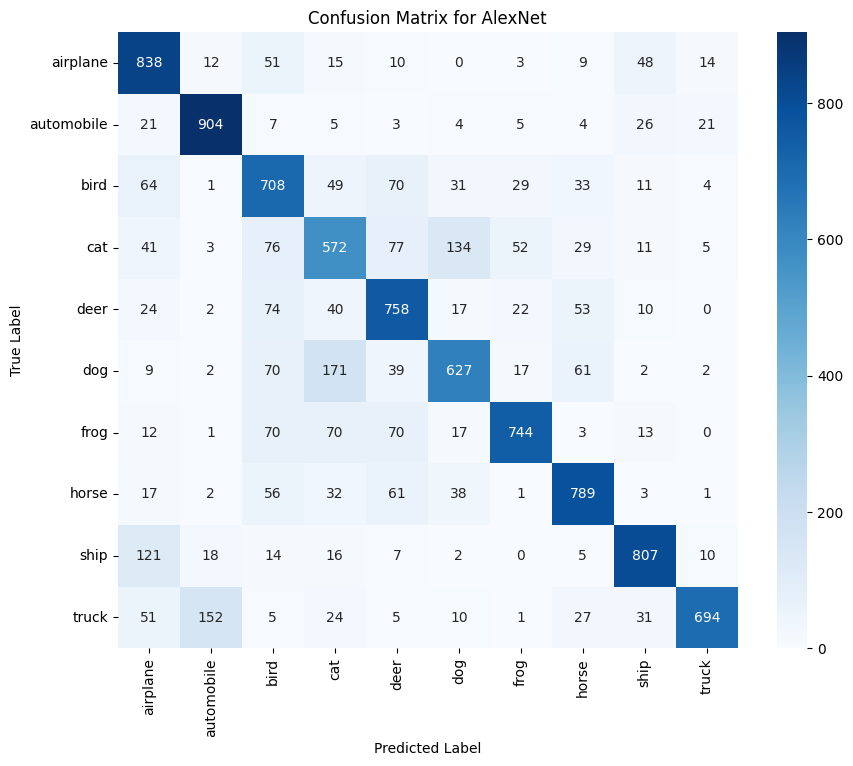

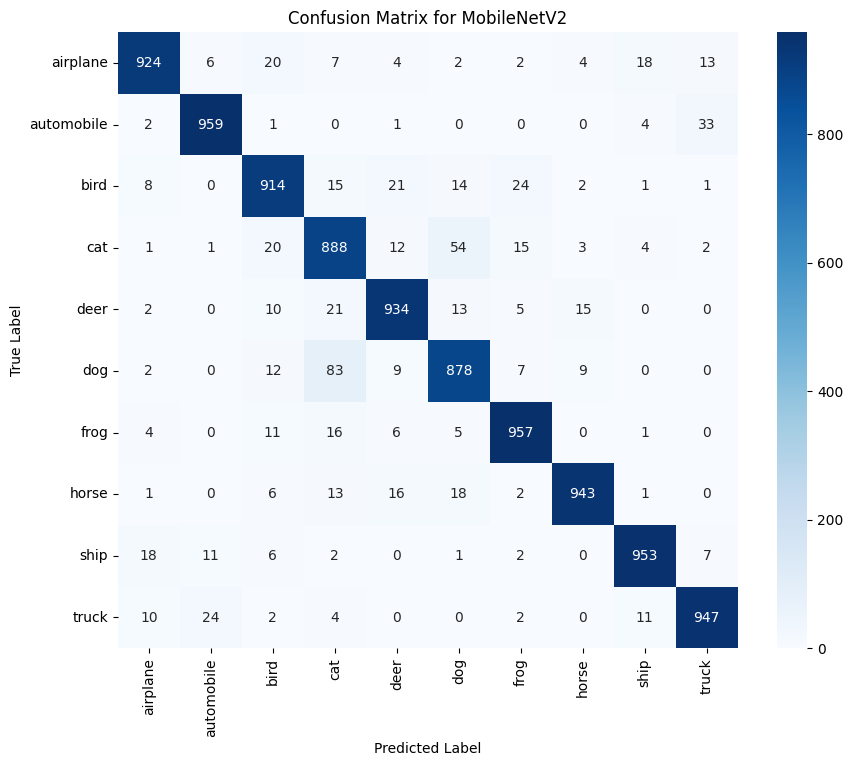

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_confusion_matrix(model, device, test_loader):
  """Generates a confusion matrix for a given model."""

  model.eval()
  all_predictions = []
  all_labels = []

  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      all_predictions.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  cm = confusion_matrix(all_labels, all_predictions)
  return cm

def plot_confusion_matrix(cm, model_name, class_names):
    """Plots a confusion matrix using seaborn."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


# Get confusion matrices for all models
resnet18_model = initialize_model("resnet18").to(device)
resnet18_model.load_state_dict(torch.load("resnet18_model.pth")) # Load your trained model weights here
resnet18_cm = get_confusion_matrix(resnet18_model, device, test_loader)

alexnet_model = initialize_model("alexnet").to(device)
alexnet_model.load_state_dict(torch.load("alexnet_model.pth")) # Load your trained model weights here
alexnet_cm = get_confusion_matrix(alexnet_model, device, test_loader)

mobilenet_v2_model = initialize_model("mobilenet_v2").to(device)
mobilenet_v2_model.load_state_dict(torch.load("mobilenet_v2_model.pth")) # Load your trained model weights here
mobilenet_v2_cm = get_confusion_matrix(mobilenet_v2_model, device, test_loader)

# Plot the confusion matrices
plot_confusion_matrix(resnet18_cm, "ResNet18", class_names)
plot_confusion_matrix(alexnet_cm, "AlexNet", class_names)
plot_confusion_matrix(mobilenet_v2_cm, "MobileNetV2", class_names)